In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
DATA_PATH = '../dataset/electricity_cost_dataset.csv'

df = pd.read_csv(DATA_PATH)

In [29]:
# Now I will proceed with each structure type seperately
df = df.drop(['recycling rate', 'air qality index', 'issue reolution time'], axis=1)

res_df = df[df['structure type'] == 'Residential']
com_df = df[df['structure type'] == 'Commercial']
ind_df = df[df['structure type'] == 'Industrial']
mix_df = df[df['structure type'] == 'Mixed-use']

res_df = res_df.drop(['structure type'], axis=1)
com_df = com_df.drop(['structure type', 'resident count'], axis=1)
ind_df = ind_df.drop(['structure type', 'resident count'], axis=1)
mix_df = mix_df.drop(['structure type'], axis=1)

In [30]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3939 entries, 3 to 9996
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   site area          3939 non-null   int64  
 1   water consumption  3939 non-null   float64
 2   utilisation rate   3939 non-null   int64  
 3   resident count     3939 non-null   int64  
 4   electricity cost   3939 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 184.6 KB


In [ ]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cost_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.reshape(-1, 1)

        # 1. Initializing parameters
        self.weights = np.zeros((n_features, 1))
        self.bias = 0.0

        # 2. Gradient Descent
        for i in range(self.n_iterations):
            # Calculate predictions
            y_pred = X @ self.weights + self.bias

            # Calculating cost (MSE)
            cost = (1 / (2 * n_samples)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)

            # Calculating the gradients
            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Updating parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Printing cost periodically
            if (i+1) % (self.n_iterations // 10) == 0 or i == 0: 
                print(f"Iteration {i+1}/{self.n_iterations}, Cost: {cost:.4f}")

    def predict(self, X):
        return X @ self.weights + self.bias

In [32]:
def normalize(X_raw: pd.DataFrame, X_test: pd.DataFrame, Y_Train: np.ndarray, Y_Test: np.ndarray):
    x_min = X_raw.min()
    x_max = X_raw.max()

    X_train_scaled = (X_raw - x_min) / (x_max - x_min)
    X_test_scaled = (X_test - x_min) / (x_max - x_min)

    y_min = Y_Train.min()
    y_max = Y_Train.max()

    Y_train_scaled = (Y_Train - y_min) / (y_max - y_min)
    Y_test_scaled = (Y_Test - y_min) / (y_max - y_min)

    return X_train_scaled.values, X_test_scaled.values, Y_train_scaled, Y_test_scaled

def custom_test_train(df: pd.DataFrame, target_col: str, train_size: float = 0.8, random_state: int = 42):
    shuffled_df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    split_index = int(len(df) * train_size)
    df_train = shuffled_df[:split_index]
    df_test = shuffled_df[split_index:]

    X_train = df_train.drop(target_col, axis=1)
    Y_train = df_train[target_col].values.reshape(-1, 1)
    X_test = df_test.drop(target_col, axis=1)
    Y_test = df_test[target_col].values.reshape(-1, 1)

    return normalize(X_train, X_test, Y_train, Y_test)

Iteration 1/10000, Cost: 0.1082
Iteration 1000/10000, Cost: 0.0020
Iteration 2000/10000, Cost: 0.0010
Iteration 3000/10000, Cost: 0.0008
Iteration 4000/10000, Cost: 0.0007
Iteration 5000/10000, Cost: 0.0007
Iteration 6000/10000, Cost: 0.0006
Iteration 7000/10000, Cost: 0.0006
Iteration 8000/10000, Cost: 0.0006
Iteration 9000/10000, Cost: 0.0006
Iteration 10000/10000, Cost: 0.0006


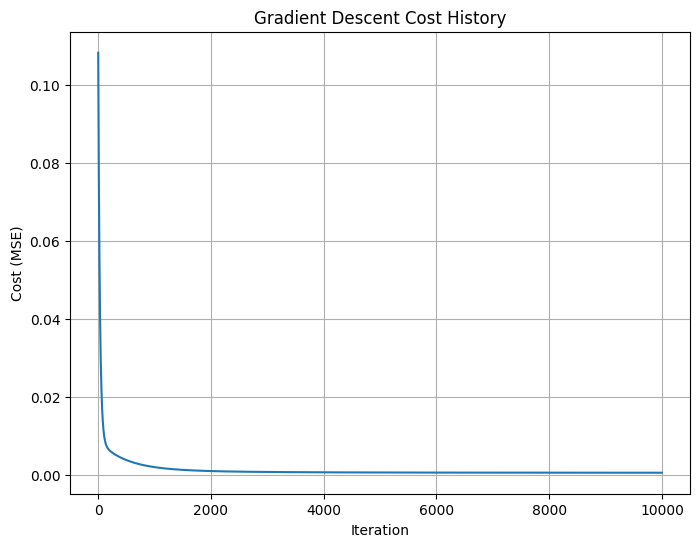

In [38]:
x_train, x_test, y_train, y_test = custom_test_train(res_df, 'electricity cost')

res_gd = LinearRegressionGD(n_iterations=10000)
res_gd.fit(x_train, y_train)

y_pred = res_gd.predict(x_test)
plt.figure(figsize=(8, 6))
plt.plot(range(len(res_gd.cost_history)), res_gd.cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE)")
plt.title("Gradient Descent Cost History")
plt.grid(True)
plt.show()


In [39]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2_score_manual(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1 - (ss_res / ss_tot)

print("\n--- Model Evaluation ---")
mse_gd_val = mse(y_test, y_pred)
r2_gd_val = r2_score_manual(y_test, y_pred)
print(f"Optimal weight (GD): {res_gd.weights[:,0]}")
print(f"Optimal Bias (GD): {res_gd.bias:.4f}")
print(f"Gradient Descent - MSE: {mse_gd_val:.4f}, R2: {r2_gd_val}")


--- Model Evaluation ---
Optimal weight (GD): [0.3668405  0.10506751 0.11716104 0.39321246]
Optimal Bias (GD): 0.0412
Gradient Descent - MSE: 0.0013, R2: 0.9659117515471627
